# SIF Data Exploration

This notebook will guide you through the steps involved in collecting solar-induced fluorescence (SIF) data from NASA's Goddard Earth Sciences Data and Information Services Center (GES DISC), an online archive that stores data from the Orbiting Carbon Observatory-3 (OCO-3) spacecraft, among others.

The first code block below will simply import some necessary helper functions for exploring and displaying the data.

In [13]:
from datetime import datetime
import numpy as np
import os
from pprint import pprint
import sys

# Add src directory containing helper code to sys.path
sys.path.append(os.path.abspath("../src"))


from geosif import GesDiscDownloader, plot_samples

# an additional helper function for displaying long lists
from IPython.display import display, Markdown
import textwrap
def wrapped_markdown_list(my_list, width=160):
    wrapped_text = textwrap.fill(", ".join(my_list), width=width)
    display(Markdown(f"```\n{wrapped_text}\n```"))

## I. Getting granules from GES DISC

The GES DISC stores various datasets associated with the OCO-2 and OCO-3 instruments, and in this training we will be focusing on the "SIF Lite" datasets as they have already received L2 processing to extract chlorophyll fluorescence signatures in the O2-A (757 nm) and O2-B  (771 nm) bands. Data is served through an OpenDAP interface that provides a browsing experience similar to looking at a directory tree. You can navigate this directory tree yourself here: [https://oco2.gesdisc.eosdis.nasa.gov/opendap/](https://oco2.gesdisc.eosdis.nasa.gov/opendap/)

A "granule" is an instrument data file, typically in netCDF (.nc or .nc4) format, containing a set of related variables from a time range of observations. Granules in general can be daily or subdaily in time cadence. In the case of the OCO3_L2_Lite_SIF.11r dataset we are are looking at today, individual netCDFs on GES DISC correspond to a signal day worth of instrument observations. 

The pydap module is able to lazily evaluate data in the archive without downloading it until needed, allowing us to explore the variables in a given granule before we download it. By the way, you may see a pydap warning when loading the data, this is no concern.

In [14]:
print("Gathering datasets on GES DISC...")
dl = GesDiscDownloader()

dataset = "OCO3_L2_Lite_SIF.11r"
print(f"Getting time range for {dataset} data...")
timerange = dl.get_dataset_timerange(dataset)
print(
    f"{dataset} has time range {timerange[0].strftime('%Y-%m-%d')} to {timerange[1].strftime('%Y-%m-%d')}"
)

Gathering datasets on GES DISC...
Getting time range for OCO3_L2_Lite_SIF.11r data...
OCO3_L2_Lite_SIF.11r has time range 2019-08-06 to 2024-11-30


In [15]:
# Get the OCO-3 SIF Lite V11r product from December 1, 2019
data_date = datetime(2019, 12, 1) # Replace with a different date if you'd like
granule = dl.get_granule_by_date(dataset, data_date)
print(f"\n\nThe {dataset} granule from {data_date.strftime('%d/%m/%Y')} has the following variables:")

wrapped_markdown_list(list(granule.keys()))



The OCO3_L2_Lite_SIF.11r granule from 01/12/2019 has the following variables:


```
Daily_SIF_757nm, Meteo_surface_pressure, Meteo_specific_humidity, Meteo_vapor_pressure_deficit, Meteo_temperature_skin, Meteo_temperature_two_meter,
Meteo_wind_speed, Longitude, SZA, SIF_740nm, Cloud_surface_albedo_abp, Cloud_delta_pressure_abp, Cloud_cloud_flag_abp, Cloud_co2_ratio, Cloud_o2_ratio,
Offset_SIF_Median_771nm, Offset_signal_histogram_757nm, Offset_SIF_Relative_SDev_771nm, Offset_SIF_Relative_SDev_757nm, Offset_SIF_Relative_Mean_771nm,
Offset_SIF_Relative_Median_771nm, Offset_SIF_Mean_771nm, Offset_signal_histogram_bins, Offset_signal_histogram_771nm, Offset_SIF_Mean_757nm,
Offset_SIF_Relative_Median_757nm, Offset_SIF_Median_757nm, Offset_SIF_Relative_Mean_757nm, Daily_SIF_740nm, Science_SIF_Unadjusted_771nm,
Science_SIF_Uncertainty_771nm, Science_SIF_Unadjusted_Relative_757nm, Science_sounding_l1b_quality_flag, Science_SIF_Relative_771nm, Science_SIF_771nm,
Science_IGBP_index, Science_SIF_757nm, Science_continuum_radiance_757nm, Science_sounding_land_fraction, Science_continuum_radiance_771nm,
Science_SIF_Unadjusted_757nm, Science_SIF_Relative_757nm, Science_SIF_Unadjusted_Relative_771nm, Science_SIF_Uncertainty_757nm, Science_daily_correction_factor,
SimplyGoodOrBadQualityFlag, Daily_SIF_771nm, Sequences_SequencesName, Sequences_SequencesMode, Sequences_SequencesId, Sequences_SequencesIndex,
Sequences_SegmentsIndex, Latitude, Diagnostics_detailed_quality_bitflag_best, Diagnostics_detailed_quality_bitflag_good,
Diagnostics_quality_bitflag_thresholds_good, Diagnostics_quality_bitflag_thresholds_best, SAz, Quality_Flag, Delta_Time, VZA, Metadata_CollectionLabel,
Metadata_BuildId, Metadata_FootprintId, Metadata_OrbitId, Metadata_MeasurementMode, Geolocation_footprint_longitude_vertices, Geolocation_sensor_azimuth_angle,
Geolocation_footprint_latitude_vertices, Geolocation_solar_azimuth_angle, Geolocation_solar_zenith_angle, Geolocation_longitude, Geolocation_latitude,
Geolocation_sensor_zenith_angle, Geolocation_altitude, Geolocation_time_tai93, VAz, SIF_Uncertainty_740nm, detailqf_dim, footprint_dim, n2, ns_17, ns_19, ns_24,
ns_5, ns_8, sequences_dim, signalbin_dim, statistics_dim, Latitude_Corners, Longitude_Corners
```

## II. Download Variables and Plot

As mentioned previously, the SIF granules contain different many different variables needed for further analysis. To get a quick sense of where observations were acquired on this particular day, we can download the Latitude and Longitude coordinates alongside the Science_SIF_757nm variable. The value for SIF is colormapped using the viridis colormap by default.

The first time you run this code block, you will get a few warnings from cartopy notifying you that it is downloading public resources for displaying the map context, this is expected and not a problem. It may take 20-30 seconds to download all the data, so please be patient.

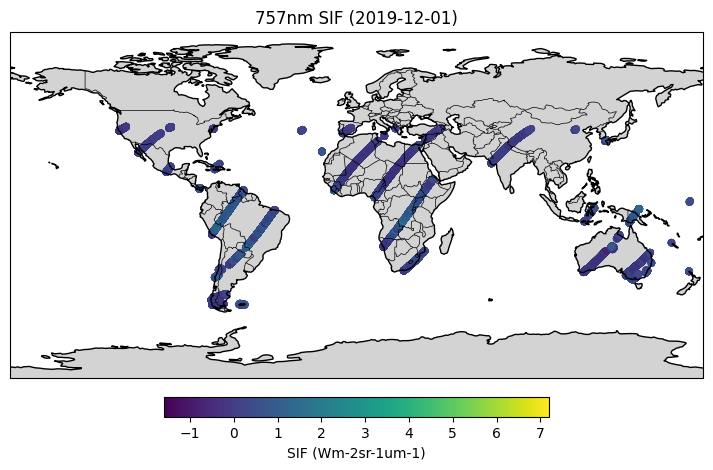

In [16]:
def get_variable_array(variable: str):
    return np.array(granule[variable].data[:])

lat = get_variable_array("Latitude")
lon = get_variable_array("Longitude")
sif = get_variable_array("Science_SIF_757nm")
plot_samples(sif, lat, lon, title="757nm SIF (2019-12-01)", label="SIF (Wm-2sr-1um-1)")